## Analysis on Arbitrum chain 

- Know what happens on arbitrum chain.
- Compare 3 NFT projects' trade volume (TofuNFT, TreasureDAO, STRATOS)


### Prerequisite

- Set Arbiscan's API Key as an env key as "ARBISCAN_APIKEY" or directly replace it
- See [here](https://arbiscan.io/myapikey) to know additional infomation

In [1]:
import datetime
import os
import requests
import time

from requests.packages.urllib3.util.retry import Retry
from requests.adapters import HTTPAdapter

import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
ARBISCAN_APIKEY = os.getenv('ARBISCAN_APIKEY')

In [3]:
s = requests.Session()
retries = Retry(total=5,
                backoff_factor=1,
                status_forcelist=[ 500, 502, 503, 504 ])

s.mount('https://', HTTPAdapter(max_retries=retries))
s.mount('http://', HTTPAdapter(max_retries=retries))

# separate functions based on whether markets' transaction is used to ETH or other token
def call_transaction(address: str) -> pd.DataFrame:
    
    # get latest block
    current_ts = int(datetime.datetime.today().timestamp())
    block_url = f"https://api.arbiscan.io/api?module=block&action=getblocknobytime&timestamp={current_ts}&closest=before&apikey={ARBISCAN_APIKEY}"
    block_result = requests.get(block_url)
    endblock = int(block_result.json()["result"])

    df = pd.DataFrame()
    max_iter = endblock // 10**6 + 1 # a bit dirty solution
    for i in range(max_iter-1):
        url = f"https://api.arbiscan.io/api?module=account&action=txlist&address={address}&startblock={i*10**6+1}&endblock={(i+1)*10**6}&sort=asc&apikey={ARBISCAN_APIKEY}"
        result = requests.get(url)
        df_tmp = pd.DataFrame(result.json()["result"])
        df = pd.concat([df, df_tmp])
        time.sleep(1)
    df["ts"] = pd.to_datetime(df.timeStamp, unit='s', utc=True)
    df["dt"] = df.ts.apply(lambda t: t.strftime("%Y-%m-%d"))
    df.value = df.value.astype("double")
    return df

def _sub_call_transaction_token(address: str, start: int, end: int) -> pd.DataFrame:
    block = (end - start) // 10
    df = pd.DataFrame()
    for i in range(10):            
        startblock = start + i * block
        endblock = end if i ==9 else start + (i + 1) * block
        url = f"https://api.arbiscan.io/api?module=account&action=tokentx&address={address}&startblock={startblock}&endblock={endblock}&sort=asc&apikey={ARBISCAN_APIKEY}"
        result = s.request('GET', url, timeout=30)
        time.sleep(1) # to avoid the api calling limitaion
        df_tmp = pd.DataFrame(result.json()["result"])
        print(f"startblock: {startblock}, endblock: {endblock}, data length: {len(df_tmp)}")
        if len(df_tmp) == 10000: # exceed the limit of api
            print(f"split the block because of reach the limit of api")
            df_tmp =  _sub_call_transaction_token(address, startblock, endblock)
        df = pd.concat([df, df_tmp])
    return df

def call_transaction_token(address: str) -> pd.DataFrame:

    # get latest block
    current_ts = int(datetime.datetime.today().timestamp())
    block_url = f"https://api.arbiscan.io/api?module=block&action=getblocknobytime&timestamp={current_ts}&closest=before&apikey={ARBISCAN_APIKEY}"
    block_result = requests.get(block_url)
    endblock = int(block_result.json()["result"])
    
    df = _sub_call_transaction_token(address, 0, endblock)
    df["ts"] = pd.to_datetime(df.timeStamp, unit='s', utc=True)
    df["dt"] = df.ts.apply(lambda t: t.strftime("%Y-%m-%d"))
    df.value = df.value.astype("double")
    return df

In [4]:
# https://arbiscan.io/address/0x7bc8b1b5aba4df3be9f9a32dae501214dc0e4f3f
TOFU_ADDRESS="0x7bc8b1B5AbA4dF3Be9f9A32daE501214dC0E4f3f"

# https://arbiscan.io/address/0xDb6Ab450178bAbCf0e467c1F3B436050d907E233
TREASURE_ADDRESS="0xDb6Ab450178bAbCf0e467c1F3B436050d907E233"

# https://help.quixotic.io/content/where-is-the-quixoticstratos-smart-contract
# https://arbiscan.io/address/0x282619db98f8a43e98065f5b306ae740d6d87a84
STRATOS_ADDRESS="0x282619dB98F8a43E98065F5B306aE740d6d87a84"

In [5]:
df_tofu = call_transaction_token(TOFU_ADDRESS)
df_treasure = call_transaction_token(TREASURE_ADDRESS)
df_stratos = call_transaction(STRATOS_ADDRESS)

startblock: 0, endblock: 1115226, data length: 0
startblock: 1115226, endblock: 2230452, data length: 0
startblock: 2230452, endblock: 3345678, data length: 0
startblock: 3345678, endblock: 4460904, data length: 214
startblock: 4460904, endblock: 5576130, data length: 7706
startblock: 5576130, endblock: 6691356, data length: 5858
startblock: 6691356, endblock: 7806582, data length: 10000
split the block because of reach the limit of api
startblock: 6691356, endblock: 6802878, data length: 793
startblock: 6802878, endblock: 6914400, data length: 788
startblock: 6914400, endblock: 7025922, data length: 2823
startblock: 7025922, endblock: 7137444, data length: 2119
startblock: 7137444, endblock: 7248966, data length: 1610
startblock: 7248966, endblock: 7360488, data length: 6988
startblock: 7360488, endblock: 7472010, data length: 4423
startblock: 7472010, endblock: 7583532, data length: 2022
startblock: 7583532, endblock: 7695054, data length: 6517
startblock: 7695054, endblock: 7806582,

In [6]:
a=df_tofu.rename(columns={"value":"tofuNFT"}) .groupby("dt").tofuNFT.sum().sort_index() // 10**18 # decimal of wrapped ether: wei
b=df_treasure.rename(columns={"value":"TreasureMarket"}).groupby("dt").TreasureMarket.sum().sort_index() // 10**18 # decimal of magic
c=df_stratos.rename(columns={"value":"STRATOS"}).groupby("dt").STRATOS.sum().sort_index() // 10**18 # decimal of ether

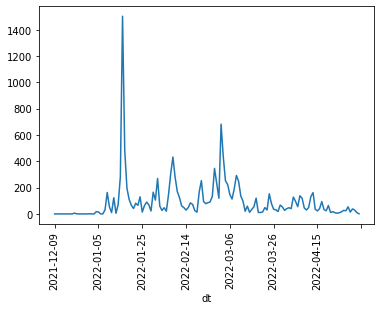

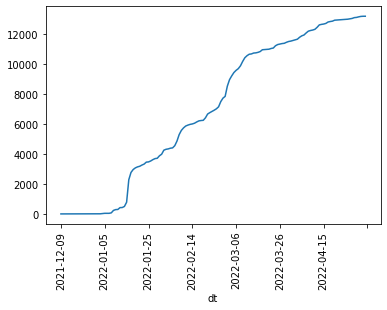

In [7]:
# tofuNFT: wrapped eth
a.plot()
plt.xticks(rotation=90)
plt.show()

a.cumsum().plot()
plt.xticks(rotation=90)
plt.show()

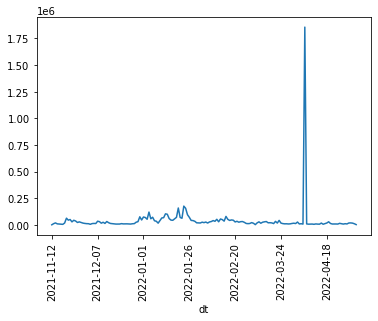

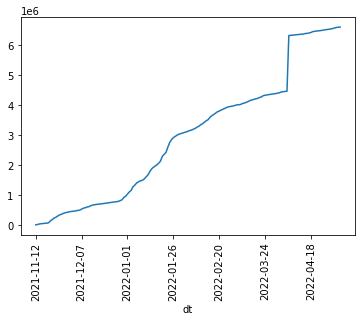

In [8]:
# TreasureMarket: MAGIC
b.plot()
plt.xticks(rotation=90)
plt.show()

b.cumsum().plot()
plt.xticks(rotation=90)
plt.show()

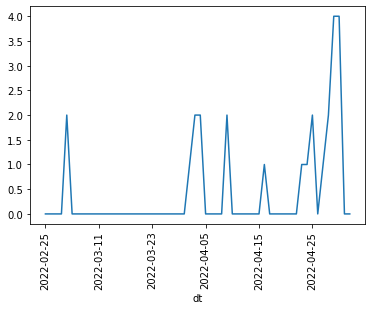

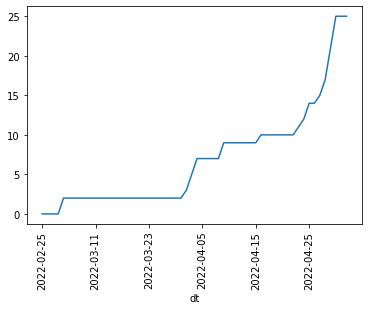

In [9]:
# STRATOS: ETH
c.plot()
plt.xticks(rotation=90)
plt.show()

c.cumsum().plot()
plt.xticks(rotation=90)
plt.show()

In [10]:
# combine all markets' data
# convert to USD at the rate on May 3rd
p = pd.DataFrame(a* 2846)
p["TreasureMarket"] = b * 1.75
p["Stratos"]=c * 2846
p = p.fillna(0)

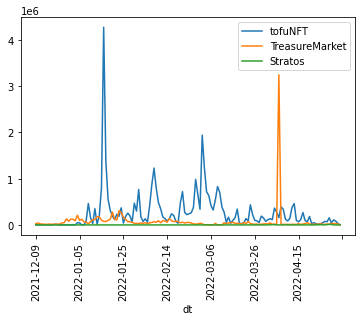

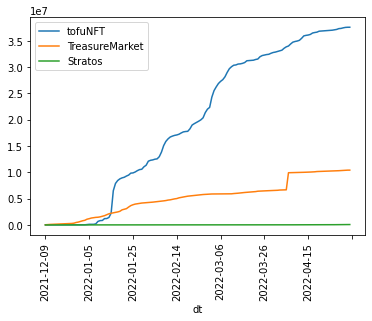

In [11]:
# plot the combinated graph
p.plot()
plt.xticks(rotation=90)
plt.show()

p.cumsum().plot()
plt.xticks(rotation=90)
plt.show()